# MNIST手写数字识别

## 一：导入库

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader 
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F 

batch_size=64
learning_rate = 0.01
momentum = 0.5 
EPOCH = 10

## 二：处理数据集

In [2]:
#用两个参数固定归一化指数函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
#下载数据集，MNIST这种著名的数据集居然在包里就预置了下载的地址
train_dataset = datasets.MNIST(root="./data/mnist",train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root="./data/mnist",train=False,download=True,transform=transform)
#将下载好的数据集打包并载入，其中的batch_size为超参数
train_loader = DataLoader(train_dataset,batch_size=batch_size , shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

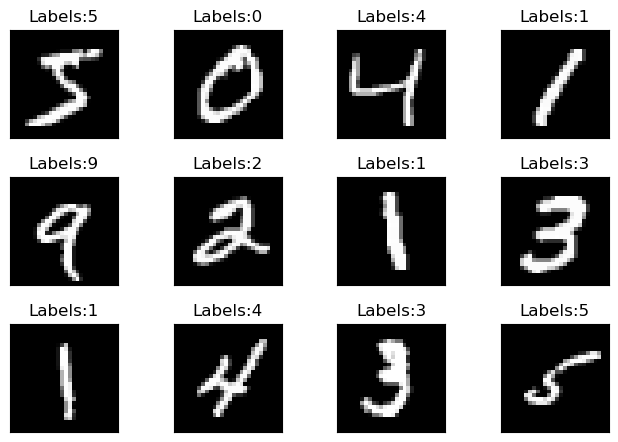

In [3]:
#本代码块用于展示数据集中的图片
fig=plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.data[i],cmap='gray',interpolation='none')
    plt.title("Labels:{}".format(train_dataset.targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


## 三：CNN

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=torch.nn.Sequential(
            torch.nn.Conv2d(1,10,kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        #第一层卷积，28*28-->24*24-->12*12，且扩展为了10块
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv2d(10,20,kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        #第二层卷积，12*12-->8*8-->4*4，且扩展为了20块
        self.fc=torch.nn.Sequential(
            torch.nn.Linear(320,50),
            torch.nn.Linear(50,10),
        )
        #全连接层通过两个线性层进行最终的预估，320个参数得到十个输出

    def forward(self,x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(batch_size, -1)
        #对于之前卷积得到的数据进行展开，得到一维的320个数据
        x = self.fc(x)
        return x
    
model = Net()

## 四：定义训练和测试

In [7]:
criterion = torch.nn.CrossEntropyLoss() #损失采用交叉熵损失
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum)#采用随机梯度下降，需要两个参数，学习率和冲量

In [10]:
def train(epoch):
    running_loss = 0.0
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader,0):
        inputs,target = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        running_loss +=loss.item()
        _, predicted = torch.max(outputs.data,dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx%300==299:
            print('[%d,%5d]: loss: %.3f, acc: %.2f %%' %(epoch+1,batch_idx+1,running_loss/300,100*running_correct / running_total))
            running_loss = 0.0
            running_total = 0
            running_correct = 0

def test():
    correct = 0
    total = 0 
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct+=(predicted==labels).sum().item()
    acc=correct/total
    print('[%d/%d]: Accuracy on test set: %.1f %% ' %(epoch+1,EPOCH,100*acc))
    return acc

## 五：开始训练

[1,  300]: loss: 0.716, acc: 79.32 %
[1,  600]: loss: 0.215, acc: 93.61 %
[1,  900]: loss: 0.163, acc: 95.20 %
[1/10]: Accuracy on test set: 96.6 % 
[2,  300]: loss: 0.121, acc: 96.38 %
[2,  600]: loss: 0.106, acc: 96.81 %
[2,  900]: loss: 0.097, acc: 97.10 %
[2/10]: Accuracy on test set: 97.9 % 
[3,  300]: loss: 0.090, acc: 97.22 %
[3,  600]: loss: 0.078, acc: 97.67 %
[3,  900]: loss: 0.077, acc: 97.72 %
[3/10]: Accuracy on test set: 98.0 % 
[4,  300]: loss: 0.068, acc: 97.80 %
[4,  600]: loss: 0.074, acc: 97.73 %
[4,  900]: loss: 0.065, acc: 98.02 %
[4/10]: Accuracy on test set: 98.2 % 
[5,  300]: loss: 0.065, acc: 98.05 %
[5,  600]: loss: 0.062, acc: 98.09 %
[5,  900]: loss: 0.056, acc: 98.31 %
[5/10]: Accuracy on test set: 98.4 % 
[6,  300]: loss: 0.048, acc: 98.53 %
[6,  600]: loss: 0.061, acc: 98.10 %
[6,  900]: loss: 0.054, acc: 98.21 %
[6/10]: Accuracy on test set: 98.5 % 
[7,  300]: loss: 0.047, acc: 98.54 %
[7,  600]: loss: 0.054, acc: 98.38 %
[7,  900]: loss: 0.050, acc: 98.

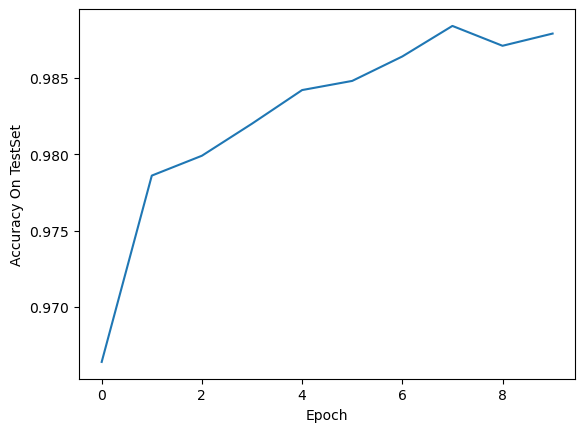

In [11]:
if __name__ == '__main__':
    acc_list_test=[]
    for epoch in range(EPOCH):
        train(epoch)
        acc_test = test()
        acc_list_test.append(acc_test)

plt.plot(acc_list_test)
plt.xlabel('Epoch')
plt.ylabel('Accuracy On TestSet')
plt.show()